In [51]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier


import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data

In [55]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=False,
                 n_data_max=10000,
                 shuffle = True)


Loading data...


c:\Users\timot\MLcompetition\utils.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = train_df.drop("change_type", 1).reindex(idx)[:n_data_max]


In [70]:
X, Y = load_data(add_knn_mean=False,
                 add_knn_concat=False,
                 n_data_max=99999999,
                 shuffle = True)


Loading data...


Fitting...


C:\Users\timot\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train score: 0.7330177409721214
Test score: 0.7084651643313747



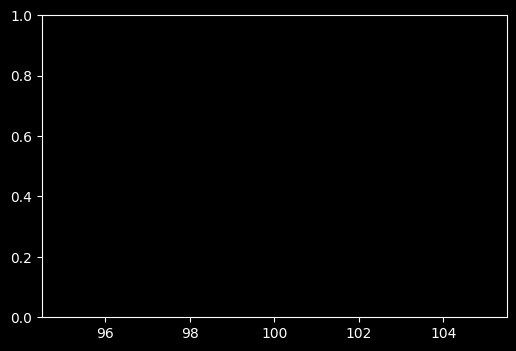

In [71]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

print('Fitting...')
L_n = [100]
L_train_score = list()
L_test_score = list()

for n in L_n:
        model = RandomForestClassifier(n_estimators=n,
                            max_depth=5,
                            min_samples_leaf=1,
                            min_samples_split=2,
                                )
        model = GradientBoostingClassifier(n_estimators=n, 
                                )
        model = XGBClassifier( 
                        n_estimators = n,
                #       scale_pos_weight=1,
                #       learning_rate=0.01,  
                #       colsample_bytree = 0.4,
                #       subsample = 0.8,
                #       objective='binary:logistic', 
                #       reg_alpha = 0.3,
                #       max_depth=4, 
                #       gamma=10
                      )
        
        eval_set = [(X_train, Y_train), (X_test, Y_test)]
        eval_metric = ["error"]
        model.fit(X_train, Y_train, 
                eval_metric=eval_metric, 
                #   eval_set=eval_set, 
                  verbose=False
                  )
        
        Y_pred          = model.predict(X_test)
        Y_pred_train    = model.predict(X_train)
        score_train = f1_score(Y_train, Y_pred_train, average = 'micro')
        score_test = f1_score(Y_test, Y_pred, average = 'micro')
        L_train_score.append(score_train)
        L_test_score.append(score_test)
        print(f"Train score: {score_train}")
        print(f"Test score: {score_test}")
        print()

plt.plot(L_n, L_train_score)
plt.plot(L_n, L_test_score)
plt.ylim(bottom = 0, top = 1)
plt.show()
